In [1]:
import os
os.chdir('../..')
import numpy as np
import torch
import pickle
from tqdm import tqdm
from rdkit.Chem import MolFromInchi
from rdkit.Chem.rdmolops import Kekulize
from sklearn.model_selection import KFold


RDKit WARNING: [17:15:13] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from molgrad.utils import DATA_PATH, EXAMPLE_PATH, MODELS_PATH
from molgrad.vis import molecule_importance
from molgrad.net import MPNNPredictor
from molgrad.train import DEVICE, SEED, N_FOLDS

Using backend: pytorch


In [3]:
FOLD_NO = 3

with open(os.path.join(DATA_PATH, "herg", "data_herg.pt"), "rb") as handle:
            inchis, values = pickle.load(handle)

inchis = np.array(inchis)
print(len(inchis))
values = np.array(values)[:, np.newaxis]

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
_, idx_test =  list(kf.split(inchis))[FOLD_NO]

inchis, values = inchis[idx_test].tolist(), values[idx_test, :].squeeze().tolist()


6993


In [4]:
sim = np.load(os.path.join(DATA_PATH, "herg", f"sim_herg_fold{FOLD_NO}.npy"))
preds = np.load(os.path.join(DATA_PATH, "herg", f"preds_fold{FOLD_NO}.npy"))
diff_true = np.load(os.path.join(DATA_PATH, "herg", f"diff_exp_fold{FOLD_NO}.npy"))
diff_hat = np.load(os.path.join(DATA_PATH, "herg", f"diff_hat_fold{FOLD_NO}.npy"))

In [5]:
sim.shape

(699, 699)

In [6]:
diff_true.shape

(699, 699)

In [7]:
diff_hat.shape

(699, 699)

In [8]:
preds.shape

(699,)

In [9]:
len(inchis)

699

In [10]:
ligand_i = []
ligand_j = []
values_i = []
values_j = []
preds_i = []
preds_j = []

long_sim = []
long_true = []
long_hat = []

for idx_i, (inchi_i, exp_i, pred_i) in enumerate(zip(inchis, values, preds)):
    for idx_j, (inchi_j, exp_j, pred_j) in enumerate(zip(inchis, values, preds)):
        if idx_i < idx_j:
            ligand_i.append(inchi_i)
            ligand_j.append(inchi_j)
            values_i.append(exp_i)
            values_j.append(exp_j)
            preds_i.append(pred_i)
            preds_j.append(pred_j)
            long_sim.append(sim[idx_i, idx_j])
            long_true.append(diff_true[idx_i, idx_j])
            long_hat.append(diff_hat[idx_i, idx_j])

In [11]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

df_pairs = pd.DataFrame({'inchi_i': ligand_i,
                         'inchi_j': ligand_j,
                         'values_i': values_i,
                         'values_j': values_j,
                         'preds_i': preds_i,
                         'preds_j': preds_j,
                         'similarity': long_sim,
                         'diff_exp': long_true,
                         'diff_pred': long_hat})


In [12]:
def sali_index(sim, diff):
    return np.abs(diff) / (1 - sim)

In [13]:
df_pairs = df_pairs.loc[df_pairs['similarity'] < 1.0]
df_pairs['sali_exp'] = sali_index(df_pairs['similarity'], df_pairs['diff_exp'])
df_pairs['sali_pred'] = sali_index(df_pairs['similarity'], df_pairs['diff_pred'])
df_pairs.sort_values('sali_pred', ascending=False, inplace=True)
df_pairs.reset_index(inplace=True)

In [14]:
df_pairs.head(n=200)

,index,inchi_i,inchi_j,values_i,values_j,preds_i,preds_j,similarity,diff_exp,diff_pred,sali_exp,sali_pred
0,193046,InChI=1S/C27H30N4O2/c32-26(24-10-15-28-21-29-2...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,6.639994,3.594993,5.803112,1.017362,0.717949,3.045000,4.785750,10.795911,16.967660
1,180221,InChI=1S/C29H33N3O4/c1-35-26-10-2-3-11-27(26)3...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,4.820000,3.594993,4.469617,1.017362,0.650794,1.225007,3.452255,3.507974,9.886003
2,151961,InChI=1S/C31H41ClFNO3/c1-2-3-4-5-6-7-8-11-30(3...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,6.613009,3.594993,8.825658,1.017362,0.208092,3.018015,7.808296,3.811070,9.860111
3,227116,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,InChI=1S/C28H29N3O4/c32-28-26-3-1-2-25(27(26)2...,3.594993,6.823909,1.017362,8.748239,0.213018,-3.228915,-7.730876,4.102907,9.823444
4,135887,InChI=1S/C22H25N3O3/c23-22(27)15-5-4-8-19(11-1...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,9.142668,3.594993,8.783083,1.017362,0.194805,5.547674,7.765721,6.889853,9.644524
5,111412,InChI=1S/C33H41N3O/c1-26-11-10-12-27(2)31(26)3...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,6.173925,3.594993,6.782078,1.017362,0.390728,2.578932,5.764716,4.232812,9.461653
6,514,InChI=1S/C21H26N2O2/c1-2-25-20-10-8-19(9-11-20...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,8.892538,3.594993,7.441879,1.017362,0.313433,5.297544,6.424517,7.715989,9.357448
7,36721,InChI=1S/C23H28N2O2/c24-23(26)18-9-4-10-21(14-...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,9.602060,3.594993,8.470675,1.017362,0.197368,6.007067,7.453313,7.484214,9.286095
8,190466,InChI=1S/C41H42F2N6O3/c42-34-7-2-6-33(25-34)41...,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,4.698970,3.594993,7.868469,1.017362,0.260000,1.103976,6.851107,1.491860,9.258252
9,227259,InChI=1S/C29H33N3O3/c1-34-26-11-4-5-12-27(26)3...,"InChI=1S/C26H26F3N5O3/c27-26(28,29)20-4-2-18-2...",3.594993,9.004365,1.017362,8.563025,0.179775,-5.409371,-7.545663,6.594987,9.199507


In [15]:
model_pt = os.path.join(MODELS_PATH, f'herg_noHs_fold{FOLD_NO}.pt')

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

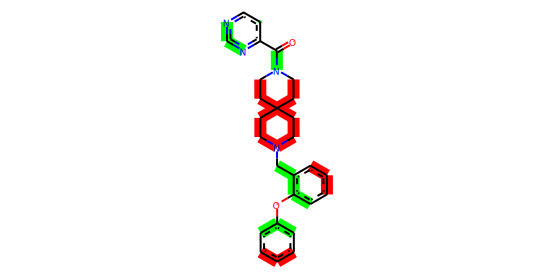

In [16]:
inchi_i, inchi_j = df_pairs.loc[0, 'inchi_i'],  df_pairs.loc[0, 'inchi_j']
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)
#Kekulize(mol_i)
#Kekulize(mol_j)
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-4,
                                                      addHs=False,
                                                      img_height=275,
                                                      img_width=550)
img

In [17]:
with open(os.path.join(EXAMPLE_PATH, "herg_cliff_oof_pos.svg"), "w+") as handle:
    handle.write(svg)

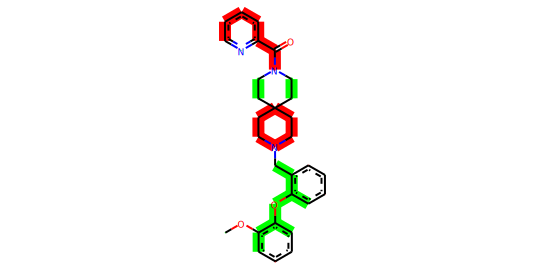

In [18]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-3,
                                                      addHs=False,
                                                      img_height=275,
                                                      img_width=550)
img

In [19]:
with open(os.path.join(EXAMPLE_PATH, "herg_cliff_oof_neg.svg"), "w+") as handle:
    handle.write(svg)